In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
####################################################################################################

import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import SchemDraw as schem

####################################################################################################

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

####################################################################################################

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *
from PySpice.Physics.SemiConductor import ShockleyDiode
from PySpice.Spice.Netlist import SubCircuitFactory

os.environ['PySpiceLibraryPath'] = '~/Projects/ROIC/src/PySpice/examples/libraries'

####################################################################################################

libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)
####################################################################################################

2018-11-26 01:51:27,970 - PySpice.Doc.ExampleTools.find_libraries - INFO - SPICE library path is ~/Projects/ROIC/src/PySpice/examples/libraries


In [2]:
class BasicOperationalAmplifier(SubCircuitFactory):

    __name__ = 'BasicOperationalAmplifier'
    __nodes__ = ('non_inverting_input', 'inverting_input', 'output')
    __pins__ = ('plus', 'minus', 'out')


    def __init__(self):

        super().__init__()

        # Input impedance
        self.R('input', 'non_inverting_input', 'inverting_input', 10@u_MΩ)

        # dc gain=100k and pole1=100hz
        # unity gain = dcgain x pole1 = 10MHZ
        self.VCVS('gain', 1, self.gnd, 'non_inverting_input', 'inverting_input', voltage_gain=kilo(100))
        self.R('P1', 1, 2, 1@u_kΩ)
        self.C('P1', 2, self.gnd, 1.5915@u_uF)

        # Output buffer and resistance
        self.VCVS('buffer', 3, self.gnd, 2, self.gnd, 1)
        self.R('out', 3, 'output', 10@u_Ω)

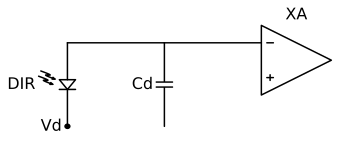

In [9]:
#r# For this purpose, we use the common high-speed diode 1N4148.  The diode is driven by a variable
#r# voltage source through a limiting current resistance.

#f# circuit_macros('diode-characteristic-curve-circuit.m4')

circuit = Circuit('Capacitive Transimpedance Amplifier (CTIA) readout')

#circuit.include(spice_library['1N4148'])


PD = circuit.D('IR', 'anode', 'Vd',
            schematic_kwargs={'schematic': schem.elements.PHOTODIODE, 
                              'd': 'down', 'show_minus': True, 'minus_label': {'lftlabel': 'Vd'},
                              'flip': True,
                             }
            )
circuit.schematic.add(schem.elements.LINE, xy=PD.schematic_element.start, d ='right')
CD = circuit.C('d', 'anode', 'Vd', 1@u_uF,
               schematic_kwargs={'schematic': schem.elements.CAP, 
                              'd': 'down', 'to': PD.schematic_element.start }
              )

circuit.subcircuit(BasicOperationalAmplifier())
circuit.schematic.add(schem.elements.LINE, xy=CD.schematic_element.start, d ='right')
XA = circuit.X('A', 'BasicOperationalAmplifier', 'Vcom', 'anode', 'Aout',
         schematic_kwargs={'schematic': schem.elements.OPAMP, 'anchor': 'in1', 
                              'd': 'right', 'flip':False})

circuit.schematic.draw()

In [ ]:
#pos = nx.spectral_layout(circuit.graph)
#nx.draw(circuit.graph, pos=pos, with_labels=True, node_size=1200,  node_shape='s',
#       width=2.0)
#edge_labels = nx.get_edge_attributes(circuit.graph,'name')
#nx.draw_networkx_edge_labels(circuit.graph, pos, edge_labels=edge_labels)



In [8]:
XA.pins

[Pin plus of XA on node Vcom,
 Pin minus of XA on node anode,
 Pin out of XA on node Aout]

In [ ]:
#r# We simulate the circuit at these temperatures: 0, 25 and 100 °C.

# Fixme: Xyce ???
temperatures = [0, 25, 100]@u_Degree
analyses = {}
for temperature in temperatures:
    simulator = circuit.simulator(temperature=temperature, nominal_temperature=temperature)
    analysis = simulator.dc(Vinput=slice(-2, 5, .01))
    analyses[float(temperature)] = analysis

####################################################################################################

In [ ]:
#r# We plot the characteristic curve and compare it to the Shockley diode model:
#r#
#r# .. math::
#r#
#r#     I_d = I_s \left( e^{\frac{V_d}{n V_T}} - 1 \right)
#r#
#r# where :math:`V_T = \frac{k T}{q}`
#r#
#r# In order to scale the reverse biased region, we have to do some hack with Matplotlib.
#r#

silicon_forward_voltage_threshold = .7

shockley_diode = ShockleyDiode(Is=4.0@u_nA, degree=25)

def two_scales_tick_formatter(value, position):
    if value >= 0:
        return '{} mA'.format(value)
    else:
        return '{} nA'.format(value/100)
formatter = ticker.FuncFormatter(two_scales_tick_formatter)

figure = plt.figure(1, (10, 5))

axe = plt.subplot(121)
axe.set_title('1N4148 Characteristic Curve ')
axe.set_xlabel('Voltage [V]')
axe.set_ylabel('Current')
axe.grid()
axe.set_xlim(-2, 2)
axe.axvspan(-2, 0, facecolor='green', alpha=.2)
axe.axvspan(0, silicon_forward_voltage_threshold, facecolor='blue', alpha=.1)
axe.axvspan(silicon_forward_voltage_threshold, 2, facecolor='blue', alpha=.2)
#axe.set_ylim(-500, 750) # Fixme: round
#axe.yaxis.set_major_formatter(formatter)
Vd = analyses[25].Vout
# compute scale for reverse and forward region
forward_region = Vd >= 0@u_V
reverse_region = np.invert(forward_region)
scale =  reverse_region*1e11 + forward_region*1e3
#?# check temperature
for temperature in temperatures:
    analysis = analyses[float(temperature)]
    axe.plot(Vd, np.abs(- analysis.Vinput))
axe.plot(Vd, np.abs(shockley_diode.I(Vd)), 'black')
axe.set_ylim(1e-9, 1e3)
axe.set_yscale('log')
axe.legend(['@ {}'.format(temperature)
            for temperature in temperatures] + ['Shockley Diode Model Is = 4 nA'],
           loc=2, fontsize=10)
axe.axvline(x=0, color='black')
axe.axhline(y=0, color='black')
axe.axvline(x=silicon_forward_voltage_threshold, color='red')
axe.text(-1, -100, 'Reverse Biased Region', ha='center', va='center')
axe.text( 1, -100, 'Forward Biased Region', ha='center', va='center')